# Exercise 06
**Integrante 1**: Andrea Carolina Parra López.................................................. 	**Código:** 201727740

**Integrante 2:** Ricardo Andrés Medina Aponte...............................................  **Código:** 201628949 


# TensorFlow and Keras


---

In [99]:
import tensorflow as tf
import numpy as np
import pylab as pl
from IPython.display import clear_output, Image, display, HTML
from sklearn.datasets.samples_generator import make_moons

%matplotlib inline


# Helper functions to inline visualization of computing graphs
# Extracted from: 
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
def strip_consts(graph_def, max_const_size=40):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=40):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

### 1. Multilayer neural network in TensorFlow

You need to create a neural network model in TF that is able to discriminate the two classes in the following dataset:

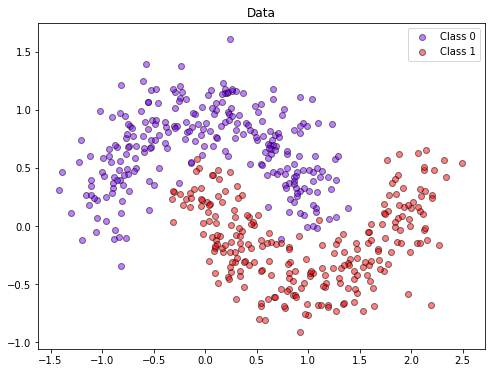

In [100]:
X, Y = make_moons(n_samples=1000, noise= 0.2, random_state=3)
x_train = X[:500]
x_test  = X[500:]
y_train = Y[:500]
y_test  = Y[500:]

pl.figure(figsize=(8, 6))
plot_data(x_train, y_train)

For this you will need to create a neural network with one hidden layer. You cannot use prebuilt models 
such as those in `tf.estimator`. **Hint**: extend the logistic regression example from the TensorFlow handout. 

Your answer must contain the following:
* A visualization of the CG of the model.

A continuación se presenta el grafo computacional de una red neuronal con una capa oculta de 15 neuronas.

In [101]:
graph = tf.Graph()
with graph.as_default():
    NumN=15
    x = tf.placeholder(tf.float32,shape=[None,2])
    y_true = tf.placeholder(tf.float32,shape=None)
    
    with tf.name_scope('Hidden-layer') as scope:
        w_1 = tf.Variable(tf.random_normal([NumN,2]),dtype=tf.float32,name='weights')
        b_1 = tf.Variable(tf.random_normal([NumN,1]),dtype=tf.float32,name='bias1')
        h=tf.sigmoid(tf.matmul(w_1,tf.transpose(x)) +b_1)
        
    with tf.name_scope('inference2') as scope: 
        w_2 = tf.Variable(tf.random_normal([1,NumN]),dtype=tf.float32,name='weights2')
        b_2 = tf.Variable(0,dtype=tf.float32,name='bias2')
        y_pred = tf.sigmoid(tf.matmul(w_2,h) + b_2)

    with tf.name_scope('loss') as scope:
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
        loss = tf.reduce_mean(loss)
  
    with tf.name_scope('train') as scope:
        learning_rate = 1.0
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

show_graph(graph.as_graph_def())

* A visualization of the decision region along with the test data.

En el siguiente gráfico se observa la función de perdida evaluando un nuevo modelo cada 50 iteraciones lo cual genera 200 pérdidas.


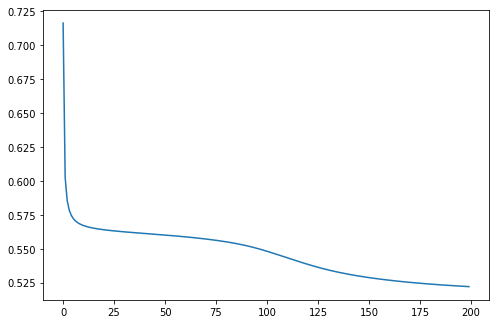

In [44]:
num_epochs = 10000
losses = []

with graph.as_default():
    sess = tf.Session()
    sess.run(init)      
    for step in range(num_epochs):
        sess.run(train,{x: x_train, y_true: y_train})
        if (step % 50 == 0):
            losses.append(sess.run(loss, {x: x_train, y_true: y_train}))
                       
pl.figure(figsize = (8,16/3))
pl.plot(losses)

En el siguiente gráfico se observa la región de predicción para cada clase.

[[ 1.6390425  -0.62045914]
 [ 7.126362    1.552752  ]
 [ 3.8039038  -1.8110439 ]
 [-0.6697686   0.9336543 ]
 [ 0.97701865 -1.2782261 ]
 [ 2.0634782  -1.7882382 ]
 [-1.4347742   0.9073293 ]
 [ 1.5441145  -1.5340407 ]
 [-1.0910388   0.65519184]
 [-3.1740458   2.5564418 ]
 [-1.6113565   1.1238773 ]
 [ 1.2704705  -2.1472154 ]
 [ 0.32477322 -0.470293  ]
 [ 2.1661837  -1.7508048 ]
 [ 6.572195    4.261272  ]]
[[1.7215883e-07]]


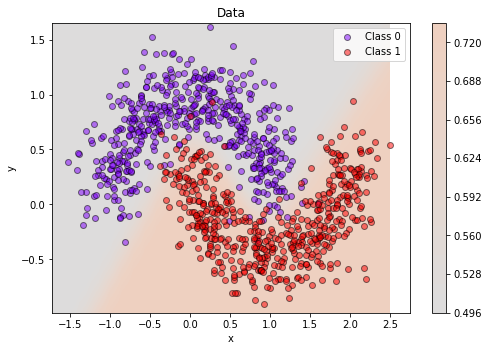

In [45]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

with graph.as_default():
    wval = sess.run(w_1)
    print(wval)
    result = sess.run(y_pred, {x:np.array([[1,2]])})
    print(result)
    def pred_fun(x1, x2):
        xval = np.array([[x1, x2]])
        return sigmoid(sess.run(y_pred,{x: xval}))

pl.figure(figsize = (8,16/3))    
plot_decision_region(x_test, pred_fun)
plot_data(X, Y)

In [46]:
 sess.close()

* A snapshot from TensorBoard that shows the evolution of the training and test loss.

In [102]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [103]:
graph = tf.Graph()
with graph.as_default():
    NumN=15
    x = tf.placeholder(tf.float32,shape=[None,2])
    y_true = tf.placeholder(tf.float32,shape=None)
    
    with tf.name_scope('Hidden-layer') as scope:
        w_1 = tf.Variable(tf.random_normal([NumN,2]),dtype=tf.float32,name='weights')
        b_1 = tf.Variable(tf.random_normal([NumN,1]),dtype=tf.float32,name='bias1')
        h=tf.sigmoid(tf.matmul(w_1,tf.transpose(x)) +b_1)
        variable_summaries(w_1)
        variable_summaries(b_1)
        
    with tf.name_scope('inference2') as scope: 
        w_2 = tf.Variable(tf.random_normal([1,NumN]),dtype=tf.float32,name='weights2')
        b_2 = tf.Variable(0,dtype=tf.float32,name='bias2')
        y_pred = tf.sigmoid(tf.matmul(w_2,h) + b_2)
        variable_summaries(w_2)
        variable_summaries(b_2)

    with tf.name_scope('loss') as scope:
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
        loss = tf.reduce_mean(loss)
        variable_summaries(loss)
         
    with tf.name_scope('train') as scope:
        learning_rate = 1.0
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train = optimizer.minimize(loss)
        
    merged = tf.summary.merge_all()
    init = tf.global_variables_initializer()

show_graph(graph.as_graph_def())

In [7]:
X, Y = make_moons(n_samples=1000, noise= 0.2, random_state=3)
x_train = X[:500]
x_test  = X[500:]
y_train = Y[:500]
y_test  = Y[500:]

LOG_DIR = 'logs'
train_writer = tf.summary.FileWriter(LOG_DIR + '/train',
                                 graph=graph)
test_writer = tf.summary.FileWriter(LOG_DIR + '/test')

num_epochs = 5000

with graph.as_default():
    with tf.Session() as sess:
        sess.run(init)      
        for step in range(num_epochs):
            summary, train_loss, _ = sess.run([merged, loss, train] ,{x: x_train, y_true: y_train})
            train_writer.add_summary(summary, step)
            summary, val_loss = sess.run([merged, loss] ,{x: x_test, y_true: y_test})
            test_writer.add_summary(summary, step)
            if step % 50 == 0:
                print(step, train_loss, val_loss)

0 0.8007625 0.77606034
50 0.63182944 0.6220043
100 0.5999757 0.59115344
150 0.5866195 0.57885206
200 0.5797598 0.5726534
250 0.5756943 0.56898814
300 0.5730248 0.56657165
350 0.57113534 0.5648522
400 0.56972045 0.56355816
450 0.5686135 0.56254226
500 0.5677171 0.5617174
550 0.5669706 0.5610291
600 0.5663335 0.56044143
650 0.5657795 0.5599298
700 0.565289 0.5594767
750 0.5648481 0.559069
800 0.5644468 0.55869764
850 0.564077 0.5583549
900 0.56373286 0.5580357
950 0.56340957 0.55773485
1000 0.563103 0.5574492
1050 0.5628105 0.557176
1100 0.5625295 0.5569125
1150 0.5622578 0.55665725
1200 0.56199384 0.55640835
1250 0.5617359 0.55616456
1300 0.561483 0.55592436
1350 0.561234 0.5556875
1400 0.5609882 0.555453
1450 0.5607446 0.55521995
1500 0.5605027 0.55498815
1550 0.56026185 0.55475694
1600 0.56002176 0.5545262
1650 0.55978197 0.5542957
1700 0.559542 0.55406487
1750 0.55930144 0.55383384
1800 0.55906045 0.5536025
1850 0.55881834 0.55337065
1900 0.55857515 0.55313843
1950 0.5583306 0.552905

In [ ]:
tensorboard --logdir="C:/Users/cayoy/Deep Learning/exercises/logs/"

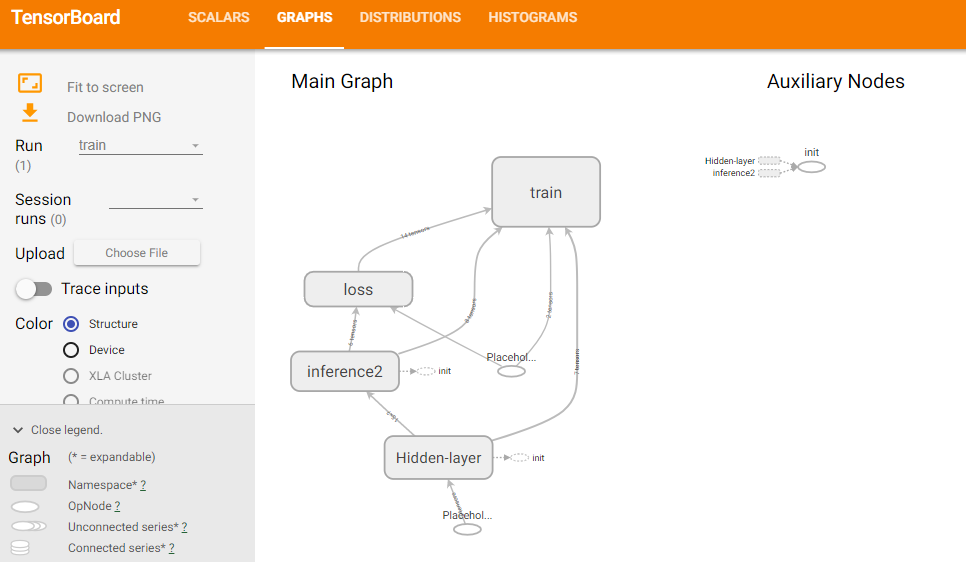

In [10]:
from IPython.display import Image
Image("ejer1.PNG")


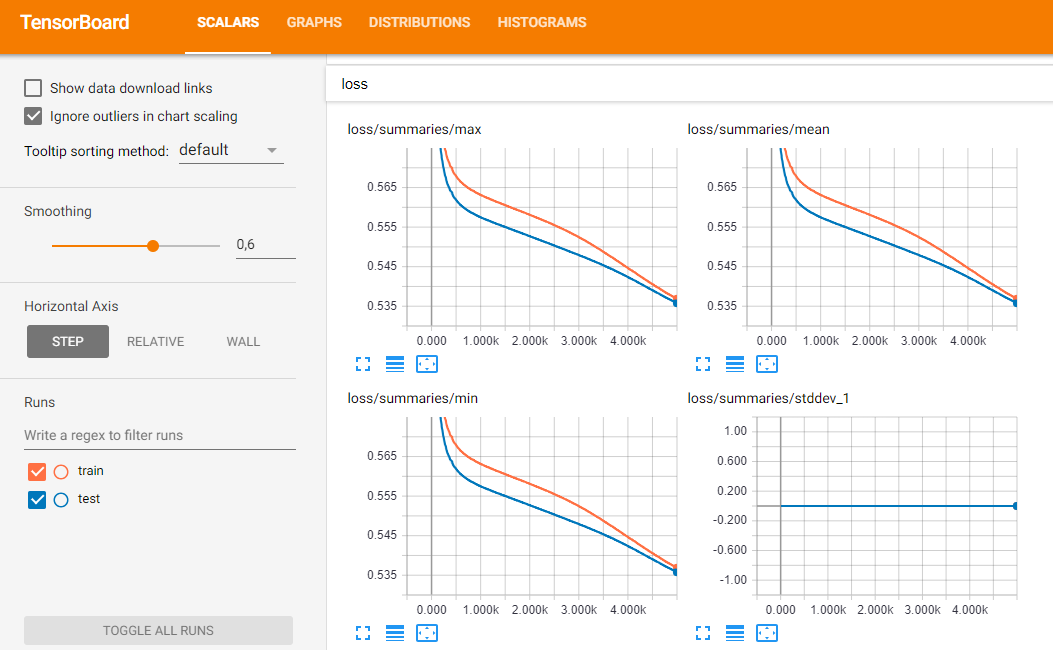

In [11]:
from IPython.display import Image
Image("ejer2.PNG")

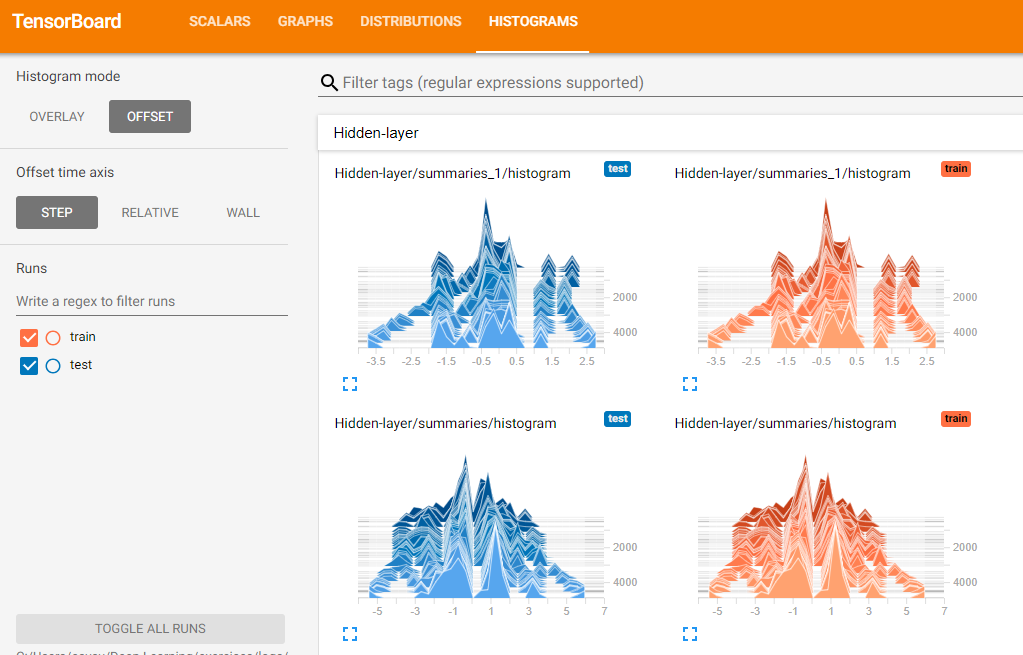

In [12]:
from IPython.display import Image
Image("ejer3.PNG")

### 2. Improving the Keras text classifier

Your goal is to improve the performance of the text classifier in the Keras handout. This is are the things that you need to try:

* Different activation functions for the hidden layer (https://keras.io/activations/)
* Different optimizers (https://keras.io/optimizers/)
* Add dropout between the hidden layer and the output layer (https://keras.io/layers/core/#dropout)
* Different initializers for the dense layers (https://keras.io/initializers/)

Try different combinations and report your findings at the end. Which configuration got the best accuracy in test?


In [106]:
from keras.datasets import reuters
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer

max_words = 1000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)#Conjunto de datos de noticias
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

Loading data...
8982 train sequences
2246 test sequences
46 classes


In [107]:
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (8982, 1000)
x_test shape: (2246, 1000)


In [108]:
import keras
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (8982, 46)
y_test shape: (2246, 46)


### Modelo 1.

Se desarrolla un modelo de 300 neuronas con función de activación sigmoide, dropout de 0.1 optimizador gradiente descendente SGD, función de pérdida categorical crossentropy e inicialización random uniform.

Este modelo presenta un accuracy de 0.51 el cual se desea mejorar cambiando los parámetros.

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()

model.add(Dense(300, input_shape=(max_words,), activation='sigmoid',kernel_initializer='random_uniform'))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))#capa de salida de 46
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 300)               300300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 46)                13846     
Total params: 314,146
Trainable params: 314,146
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 276us/step - loss: 2.4844 - acc: 0.3631 - val_loss: 2.3143 - val_acc: 0.4093
Epoch 2/5
8083/8083 [==============================] - 2s 222us/step - loss: 2.2121 - acc: 0.4245 - val_loss: 2.1913 - val_acc: 0.4338
Epoch 3/5
8083/8083 [==============================] - 2s 219us/step - loss: 2.1028 - acc: 0.4597 - val_loss: 2.1095 - val_acc: 0.4950
Epoch 4/5
8083/8083 [==============================] - 2s 221us/step - loss: 2.0250 - acc: 0.4867 - val_loss: 2.0395 - val_acc: 0.4894
Epoch 5/5
8083/8083 [==============================] - 2s 221us/step - loss: 1.9631 - acc: 0.5015 - val_loss: 1.9747 - val_acc: 0.5117


In [50]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 77us/step
Test score: 1.934592231086398
Test accuracy: 0.5178094390292095


### Modelo 2

Se desarrolla un modelo de 300 neuronas con función de activación relu, dropout de 0.5 optimizador gradiente descendente SGD, función de pérdida categorical crossentropy e inicialización random uniform.

Este modelo presenta un accuracy de 0.67 el cual mejora con respecto al primer modelo.

In [58]:
model = Sequential()

model.add(Dense(300, input_shape=(max_words,), activation='relu',kernel_initializer='random_uniform'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))#capa de salida de 46
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 300)               300300    
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 46)                13846     
Total params: 314,146
Trainable params: 314,146
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 263us/step - loss: 2.4821 - acc: 0.4524 - val_loss: 1.9456 - val_acc: 0.5139
Epoch 2/5
8083/8083 [==============================] - 2s 234us/step - loss: 1.8320 - acc: 0.5518 - val_loss: 1.7229 - val_acc: 0.5996
Epoch 3/5
8083/8083 [==============================] - 2s 229us/step - loss: 1.6651 - acc: 0.6015 - val_loss: 1.6085 - val_acc: 0.6407
Epoch 4/5
8083/8083 [==============================] - 2s 229us/step - loss: 1.5584 - acc: 0.6357 - val_loss: 1.5249 - val_acc: 0.6785
Epoch 5/5
8083/8083 [==============================] - 2s 230us/step - loss: 1.4661 - acc: 0.6620 - val_loss: 1.4617 - val_acc: 0.6919


In [60]:
score2 = model.evaluate(x_test, y_test)
print('Test score:', score2[0])
print('Test accuracy:', score2[1])

2246/2246 [==============================] - 0s 75us/step
Test score: 1.4510762689374752
Test accuracy: 0.6736420303025844


### Modelo 3

Se desarrolla un modelo de 300 neuronas con función de activación tangente hiperbólica tanh, dropout de 0.6 optimizador gradiente descendente SGD, función de pérdida categorical crossentropy e inicialización random uniform.

Este modelo presenta un accuracy de 0.69 el cual mejora en dos puntos  con respecto al segundo modelo.

In [64]:
model = Sequential()

model.add(Dense(300, input_shape=(max_words,), activation='tanh',kernel_initializer='random_uniform'))
model.add(Dropout(0.6))
model.add(Dense(num_classes, activation='softmax'))#capa de salida de 46
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 300)               300300    
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 46)                13846     
Total params: 314,146
Trainable params: 314,146
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 292us/step - loss: 2.2678 - acc: 0.4795 - val_loss: 1.8348 - val_acc: 0.5673
Epoch 2/5
8083/8083 [==============================] - 2s 238us/step - loss: 1.7332 - acc: 0.5827 - val_loss: 1.6387 - val_acc: 0.6318
Epoch 3/5
8083/8083 [==============================] - 2s 238us/step - loss: 1.5627 - acc: 0.6387 - val_loss: 1.5264 - val_acc: 0.6763
Epoch 4/5
8083/8083 [==============================] - 2s 226us/step - loss: 1.4535 - acc: 0.6676 - val_loss: 1.4428 - val_acc: 0.6874
Epoch 5/5
8083/8083 [==============================] - 2s 238us/step - loss: 1.3722 - acc: 0.6891 - val_loss: 1.3850 - val_acc: 0.7019


In [66]:
score2 = model.evaluate(x_test, y_test)
print('Test score:', score2[0])
print('Test accuracy:', score2[1])

2246/2246 [==============================] - 0s 82us/step
Test score: 1.3711965780436515
Test accuracy: 0.6901157613800555


### Modelo 4

Se desarrolla un modelo de 300 neuronas con función de activación relu, dropout de 0.5 optimizador gradiente descendente SGD, función de pérdida categorical crossentropy y se modifica la inicialización a random normal.

Este modelo presenta un accuracy de 0.65 el cual empeora con respecoto al tercer modelo.

In [67]:
model = Sequential()

model.add(Dense(300, input_shape=(max_words,), activation='relu',kernel_initializer='random_normal'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))#capa de salida de 46
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 300)               300300    
_________________________________________________________________
dropout_8 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 46)                13846     
Total params: 314,146
Trainable params: 314,146
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 291us/step - loss: 2.4968 - acc: 0.4396 - val_loss: 1.9460 - val_acc: 0.5261
Epoch 2/5
8083/8083 [==============================] - 2s 249us/step - loss: 1.8730 - acc: 0.5401 - val_loss: 1.7455 - val_acc: 0.5918
Epoch 3/5
8083/8083 [==============================] - 2s 246us/step - loss: 1.7154 - acc: 0.5821 - val_loss: 1.6369 - val_acc: 0.6263
Epoch 4/5
8083/8083 [==============================] - 2s 255us/step - loss: 1.6063 - acc: 0.6180 - val_loss: 1.5622 - val_acc: 0.6596
Epoch 5/5
8083/8083 [==============================] - 2s 245us/step - loss: 1.5289 - acc: 0.6370 - val_loss: 1.5004 - val_acc: 0.6741


In [69]:
score2 = model.evaluate(x_test, y_test)
print('Test score:', score2[0])
print('Test accuracy:', score2[1])

2246/2246 [==============================] - 0s 78us/step
Test score: 1.497011244987019
Test accuracy: 0.6576135352001802


### Modelo 5
Se desarrolla un modelo de 300 neuronas con función de activación tangente hiperbólica tanh, dropout de 0.6 optimizador gradiente descendente SGD, función de pérdida categorical crossentropy e inicialización random normal.

Este modelo muestra un accuracy de 0.67, no presenta mejoras con respecto a los modelos anteriores, ahora se modificará la función de pérdida y el optimizador.

In [70]:
model = Sequential()

model.add(Dense(300, input_shape=(max_words,), activation='tanh',kernel_initializer='random_normal'))
model.add(Dropout(0.6))
model.add(Dense(num_classes, activation='softmax'))#capa de salida de 46
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 300)               300300    
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 46)                13846     
Total params: 314,146
Trainable params: 314,146
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 285us/step - loss: 2.3661 - acc: 0.4592 - val_loss: 1.8390 - val_acc: 0.5539
Epoch 2/5
8083/8083 [==============================] - 2s 224us/step - loss: 1.7957 - acc: 0.5750 - val_loss: 1.6478 - val_acc: 0.6307
Epoch 3/5
8083/8083 [==============================] - 2s 246us/step - loss: 1.6202 - acc: 0.6164 - val_loss: 1.5392 - val_acc: 0.6741
Epoch 4/5
8083/8083 [==============================] - 2s 292us/step - loss: 1.5239 - acc: 0.6467 - val_loss: 1.4611 - val_acc: 0.6952
Epoch 5/5
8083/8083 [==============================] - 2s 298us/step - loss: 1.4165 - acc: 0.6707 - val_loss: 1.4033 - val_acc: 0.6986


In [72]:
score2 = model.evaluate(x_test, y_test)
print('Test score:', score2[0])
print('Test accuracy:', score2[1])

2246/2246 [==============================] - 0s 107us/step
Test score: 1.3925058969088357
Test accuracy: 0.6767586821280519


###### Modelo 6
Se desarrolla un modelo de 300 neuronas con función de activación tangente hiperbólica tanh, dropout de 0.6 optimizador gradiente descendente SGD, función de pérdida categorical crossentropy e inicialización Zeros.

Este modelo presenta un accuracy de **0.70** el cual mejora con respecto a los modelos anteriores.

In [112]:
model = Sequential()

model.add(Dense(300, input_shape=(max_words,), activation='tanh',kernel_initializer='Zeros'))
model.add(Dropout(0.6))
model.add(Dense(num_classes, activation='softmax'))#capa de salida de 46
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 300)               300300    
_________________________________________________________________
dropout_19 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 46)                13846     
Total params: 314,146
Trainable params: 314,146
Non-trainable params: 0
_________________________________________________________________


In [113]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 6s 778us/step - loss: 2.1919 - acc: 0.5184 - val_loss: 1.8040 - val_acc: 0.5773
Epoch 2/5
8083/8083 [==============================] - 3s 397us/step - loss: 1.6701 - acc: 0.6065 - val_loss: 1.6150 - val_acc: 0.6496
Epoch 3/5
8083/8083 [==============================] - 4s 434us/step - loss: 1.5028 - acc: 0.6614 - val_loss: 1.5016 - val_acc: 0.6774
Epoch 4/5
8083/8083 [==============================] - 4s 435us/step - loss: 1.3957 - acc: 0.6865 - val_loss: 1.4227 - val_acc: 0.6941
Epoch 5/5
8083/8083 [==============================] - 3s 422us/step - loss: 1.3106 - acc: 0.7080 - val_loss: 1.3652 - val_acc: 0.7030


In [114]:
score2 = model.evaluate(x_test, y_test)
print('Test score:', score2[0])
print('Test accuracy:', score2[1])

2246/2246 [==============================] - 0s 113us/step
Test score: 1.345821773167285
Test accuracy: 0.7039180766071258


### Modelo 7.

Se prueba el modelo anterior modicando la función de activación por Relu y el dropout a 0.5 y el inicializador a random uniform, adicionalmente se modifica el algoritmo de optimización utilizando RMSprop.

Este modelo presenta un accuracy de **0.79** el cual mejora considerablemente con respecto al modelo anterior.

In [122]:
model = Sequential()

model.add(Dense(300, input_shape=(max_words,), activation='relu',kernel_initializer='random_uniform'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))#capa de salida de 46
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 300)               300300    
_________________________________________________________________
dropout_22 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 46)                13846     
Total params: 314,146
Trainable params: 314,146
Non-trainable params: 0
_________________________________________________________________


In [123]:
from keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 4s 434us/step - loss: 1.4497 - acc: 0.6812 - val_loss: 1.1992 - val_acc: 0.7531
Epoch 2/5
8083/8083 [==============================] - 3s 331us/step - loss: 0.9397 - acc: 0.7924 - val_loss: 1.0977 - val_acc: 0.7809
Epoch 3/5
8083/8083 [==============================] - 3s 368us/step - loss: 0.7555 - acc: 0.8326 - val_loss: 1.0522 - val_acc: 0.7976
Epoch 4/5
8083/8083 [==============================] - 3s 345us/step - loss: 0.6497 - acc: 0.8564 - val_loss: 1.0940 - val_acc: 0.7942
Epoch 5/5
8083/8083 [==============================] - 3s 333us/step - loss: 0.5629 - acc: 0.8762 - val_loss: 1.1052 - val_acc: 0.7976


In [124]:
score2 = model.evaluate(x_test, y_test)
print('Test score:', score2[0])
print('Test accuracy:', score2[1])

2246/2246 [==============================] - 0s 89us/step
Test score: 1.0418228824968754
Test accuracy: 0.7929652715939448


### Modelo 8.

Se prueba el modelo anterior modicando el algoritmo de optimización utilizando Adagrad.

Este modelo presenta un accuracy de **0.79** el cual es parecido en el modelo anterior.

In [125]:
model = Sequential()

model.add(Dense(300, input_shape=(max_words,), activation='relu',kernel_initializer='random_uniform'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))#capa de salida de 46
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 300)               300300    
_________________________________________________________________
dropout_23 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 46)                13846     
Total params: 314,146
Trainable params: 314,146
Non-trainable params: 0
_________________________________________________________________


In [126]:
from keras.optimizers import adagrad
model.compile(loss='categorical_crossentropy', optimizer=adagrad(), metrics=['accuracy'])
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 4s 453us/step - loss: 1.2989 - acc: 0.7064 - val_loss: 1.1183 - val_acc: 0.7631
Epoch 2/5
8083/8083 [==============================] - 2s 301us/step - loss: 0.8719 - acc: 0.8002 - val_loss: 1.0134 - val_acc: 0.7786
Epoch 3/5
8083/8083 [==============================] - 2s 304us/step - loss: 0.7091 - acc: 0.8342 - val_loss: 0.9439 - val_acc: 0.7953
Epoch 4/5
8083/8083 [==============================] - 2s 302us/step - loss: 0.6099 - acc: 0.8580 - val_loss: 0.9123 - val_acc: 0.7887
Epoch 5/5
8083/8083 [==============================] - 2s 306us/step - loss: 0.5422 - acc: 0.8702 - val_loss: 0.8888 - val_acc: 0.7987


In [127]:
score2 = model.evaluate(x_test, y_test)
print('Test score:', score2[0])
print('Test accuracy:', score2[1])

2246/2246 [==============================] - 0s 89us/step
Test score: 0.864659000483349
Test accuracy: 0.7916295636687445


### Modelo seleccionado.
Teniendo en cuenta los test de loa anteriores modelos se escoge el **modelo 7** el cual  cuenta con las siguientes caracteríaticas:

* Una capa oculta de 300 neuronas.
* Función de Activación Relu.
* Dropout de 0.5.
* Función de inicialización random uniform.
* Algoritmo de optimización RMSprop.
* Función de pérdida categorical crossentropy.

Con este modelo se obtiene un **accuracy: 0.7929**

    